### Imports & Setup

In [699]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False

### Preparazione dei tre dataset (Industriale, Scolastico e Residenziale)

In [700]:
import pandas as pd

df = pd.read_csv(
    "/home/samuel/Desktop/Appunti/Insite/TensorFlow/time-series-forcasting/opsd-household_data-2020-04-15/household_data_15min_singleindex.csv"
)

df_industrial = df.copy()
df_residential = df.copy()
df_school = df.copy()

timestamp_column = "utc_timestamp"

data_column_industrial = "DE_KN_industrial1_grid_import"
data_column_school = "DE_KN_public1_grid_import"
data_column_residential = "DE_KN_residential1_grid_import"

df_industrial = df_industrial[[timestamp_column, data_column_industrial]]
df_residential = df_residential[[timestamp_column, data_column_residential]]
df_school = df_school[[timestamp_column, data_column_school]]

# Calcolo della differenza tra il valore corrente e quello precedente nella colonna, ottenendo così il consumo istantaneo
df_industrial[f"{data_column_industrial}_instantaneous"] = df_industrial[
    data_column_industrial
].diff()
df_residential[f"{data_column_residential}_instantaneous"] = df_residential[
    data_column_residential
].diff()
df_school[f"{data_column_school}_instantaneous"] = df_school[data_column_school].diff()


# Rimuove righe con campi vuoti
df_industrial.dropna(inplace=True)
df_residential.dropna(inplace=True)
df_school.dropna(inplace=True)

df_industrial
df_residential
df_school

,utc_timestamp,DE_KN_public1_grid_import,DE_KN_public1_grid_import_instantaneous
50178,2016-05-17T10:15:00Z,0.428,0.395
50179,2016-05-17T10:30:00Z,0.755,0.327
50180,2016-05-17T10:45:00Z,1.105,0.350
50181,2016-05-17T11:00:00Z,1.695,0.590
50182,2016-05-17T11:15:00Z,2.166,0.471
...,...,...,...
68369,2016-11-22T22:00:00Z,12312.401,0.352
68370,2016-11-22T22:15:00Z,12312.767,0.366
68371,2016-11-22T22:30:00Z,12313.153,0.386
68372,2016-11-22T22:45:00Z,12313.510,0.357


#### Rimozione della colonna timestamp e Import cumulativo

Rimuoviamo la colonna timestamp in quanto si tratta di una stringa, e quindi andrebbe sempre esclusa nel calcolo di medie, deviazioni standard e nei grafici che faremo più avanti sui dataset. Tale valore verrà reinserito più avanti come valore puramente numerico.

Rimuoviamo inoltre anche la colonna di import cumulativo perché non necessaria per il modello.

In [701]:
date_time_industrial = pd.to_datetime(
    df_industrial.pop(timestamp_column), format="ISO8601"
)

date_time_residential = pd.to_datetime(
    df_residential.pop(timestamp_column), format="ISO8601"
)

date_time_school = pd.to_datetime(df_school.pop(timestamp_column), format="ISO8601")

# Eliminazione della colonna di import cumulativo

cumulative_import_industrial = df_industrial.pop(data_column_industrial)

cumulative_import_residential = df_residential.pop(data_column_residential)

cumulative_import_school = df_school.pop(data_column_school)

#### Grafici e Statistiche

In [702]:
# # Decommentare per plottare nuovi grafici
# plot_cols = [data_column_industrial, f"{data_column_industrial}_instantaneous"]
# plot_features = df_industrial[plot_cols][:5000]
# plot_features.index = date_time_industrial[:5000]
# _ = plot_features.plot(subplots=True)

# plot_cols = [data_column_residential, f"{data_column_residential}_instantaneous"]
# plot_features = df_residential[plot_cols][:5000]
# plot_features.index = date_time_residential[:5000]
# _ = plot_features.plot(subplots=True)

# plot_cols = [data_column_school, f"{data_column_school}_instantaneous"]
# plot_features = df_school[plot_cols][:5000]
# plot_features.index = date_time_school[:5000]
# _ = plot_features.plot(subplots=True)

![Grid Import Industrial](resources/industrial_grid_import_15min.png "Grid Import Industrial")

![Grid Import Residential](resources/residential_grid_import_15min.png "Grid Import Residential")

![Grid Import School](resources/school_grid_import_15min.png "Grid Import School")

In [703]:
df_industrial.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DE_KN_industrial1_grid_import_instantaneous,65729.0,7.776053,4.745445,0.688,4.391,6.875,10.125,40.828


In [704]:
df_residential.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DE_KN_residential1_grid_import_instantaneous,63486.0,0.143281,0.115451,0.029,0.09,0.11,0.145,1.663


In [705]:
df_school.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DE_KN_public1_grid_import_instantaneous,18196.0,0.676715,0.757493,0.036,0.279,0.361,0.615,5.113


Una volta visualizzati i dati contenuti nei dataset e misure come deviazione standard, minimi e massimi, possiamo giudicare la qualità del dataset, ed eventualmente eliminare dati nulli o errati (ad esempio se notiamo minimi o massimi che non hanno senso).
In questo caso, a parte la rimozione dei campi vuoti già effettuata, possiamo tenere i dataset così come sono.

#### Coversione della data

Affinché i modelli performino al meglio, ha senso passare al modello, invece che la data o il timestamp, il periodo dell'anno e l'ora del giorno, dal momento che in base a queste due frequenze varia l'utilizzo di energia.

In [706]:
day = 24 * 60 * 60
# Considerando la durata reale di un anno, non dobbiamo tenere conto di anni bisestili
# DISCUSS potrebbe essere che così la predizione del modello sia incorretta in vicinanza delle festività
year = (365.2425) * day

timestamp_seconds_industrial = date_time_industrial.map(pd.Timestamp.timestamp)

df_industrial["Day sin"] = np.sin(timestamp_seconds_industrial * (2 * np.pi / day))
df_industrial["Day cos"] = np.cos(timestamp_seconds_industrial * (2 * np.pi / day))
df_industrial["Year sin"] = np.sin(timestamp_seconds_industrial * (2 * np.pi / year))
df_industrial["Year cos"] = np.cos(timestamp_seconds_industrial * (2 * np.pi / year))

timestamp_seconds_residential = date_time_residential.map(pd.Timestamp.timestamp)

df_residential["Day sin"] = np.sin(timestamp_seconds_residential * (2 * np.pi / day))
df_residential["Day cos"] = np.cos(timestamp_seconds_residential * (2 * np.pi / day))
df_residential["Year sin"] = np.sin(timestamp_seconds_residential * (2 * np.pi / year))
df_residential["Year cos"] = np.cos(timestamp_seconds_residential * (2 * np.pi / year))

timestamp_seconds_school = date_time_industrial.map(pd.Timestamp.timestamp)

df_school["Day sin"] = np.sin(timestamp_seconds_school * (2 * np.pi / day))
df_school["Day cos"] = np.cos(timestamp_seconds_school * (2 * np.pi / day))
df_school["Year sin"] = np.sin(timestamp_seconds_school * (2 * np.pi / year))
df_school["Year cos"] = np.cos(timestamp_seconds_school * (2 * np.pi / year))

# # Decommentare per plottare nuovi grafici
# plot_cols = ['Day sin', 'Day cos']
# plot_features = df_industrial[plot_cols][:96]
# plot_features.index = date_time_industrial[:96]
# _ = plot_features.plot(subplots=True)

# plot_cols = ['Year sin', 'Year cos']
# plot_features = df_industrial[plot_cols][:35064]
# plot_features.index = date_time_industrial[:35064]
# _ = plot_features.plot(subplots=True)

![Segnale Seno e Coseno Timestamp Periodo Giornaliero](resources/timestamp_day_encoding.png "Segnale Seno e Coseno Timestamp Periodo Giornaliero")
![Segnale Seno e Coseno Timestamp Periodo Annuale](resources/timestamp_year_encoding.png "Segnale Seno e Coseno Timestamp Periodo Annuale")

#### Analisi delle frequenze migliori tramite trasformate di Fourier

Non dobbiamo usare necessariamente quello giornaliero e quello annuale come periodi per codificare i timestamp nei dataset; a seconda del dataset o del caso di utilizzo potrebbero infatti esserci frequenze migliori. Per ricavare tali frequenze possiamo applicare delle trasformate di Fourier ai dati registrati e cercare le frequenze che hanno maggiore peso nel risultato finale.

__NB__: È da approfondire la questione dei __buchi nei dataset__, questi infatti se non vengono tolti, non permettono di eseguire le trasforamte di Fourier, ma anche togliendoli, ed eseguendo le trasformate di Fourier, se ci sono buchi troppo grandi, si rischia di avere dei risultati finali falsati.

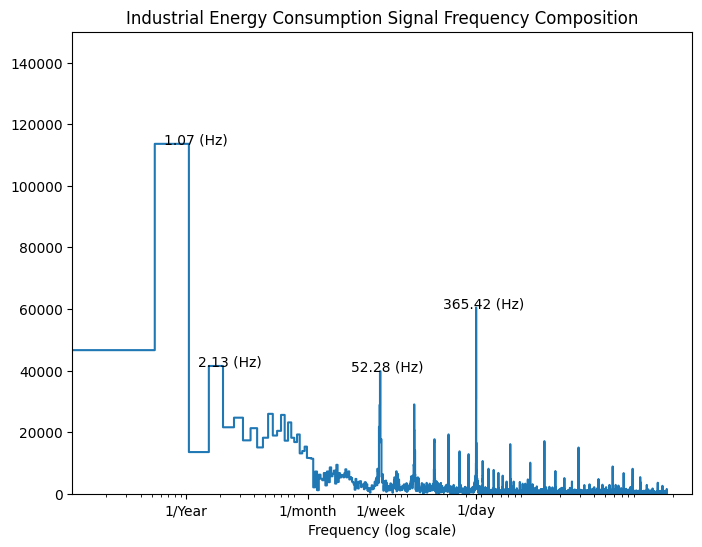

In [707]:
fft = tf.signal.rfft(df_industrial[f"{data_column_industrial}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df_industrial[f"{data_column_industrial}_instantaneous"])
# Ricavo i quarti d'ora in un anno dal momento che abbiamo un sample ogni quarto d'ora
hours_quarters_per_year = 24 * 365.2524 * 4
years_per_dataset = n_samples / (hours_quarters_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 150000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks(
    [1, 12, 365.2524 / 7, 365.2524], labels=["1/Year", "1/month", "1/week", "1/day"]
)
_ = plt.xlabel("Frequency (log scale)")
_ = plt.title("Industrial Energy Consumption Signal Frequency Composition")

# Ricerca dei valori massimi dei "pesi" delle frequenze
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
    if f_per_year[idx] >= 1 and not any(
        [
            # TODO verifica che log(last_frequency) sia una buona funzione per stabilire l'intervallo
            abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
            for last_frequency in f_per_year[top_4_indices]
        ]
        if top_4_indices
        else [False]
    ):
        top_4_indices.append(idx)
        if len(top_4_indices) == 4:
            break  # Stop after finding 4 valid frequencies
top_4_frequencies_industrial = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_industrial, top_4_magnitudes)):
    plt.annotate(
        f"{freq:.2f} (Hz)",
        (freq, mag),
        xytext=(5, 0),
        textcoords="offset points",
        ha="center",
    )

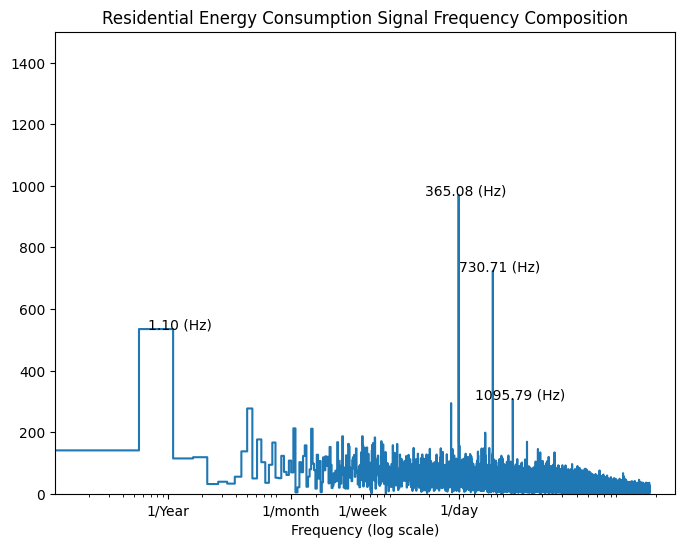

In [708]:
fft = tf.signal.rfft(df_residential[f"{data_column_residential}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df_residential[f"{data_column_residential}_instantaneous"])
hours_quarters_per_year = 24 * 365.2524 * 4
years_per_dataset = n_samples / (hours_quarters_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 1500)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks(
    [1, 12, 365.2524 / 7, 365.2524], labels=["1/Year", "1/month", "1/week", "1/day"]
)
_ = plt.xlabel("Frequency (log scale)")
_ = plt.title("Residential Energy Consumption Signal Frequency Composition")


# Ricerca dei valori massimi dei "pesi" delle frequenze
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
    if f_per_year[idx] >= 1 and not any(
        [
            # TODO verifica che log(last_frequency) sia una buona funzione per stabilire l'intervallo
            abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
            for last_frequency in f_per_year[top_4_indices]
        ]
        if top_4_indices
        else [False]
    ):
        top_4_indices.append(idx)
        if len(top_4_indices) == 4:
            break  # Stop after finding 4 valid frequencies
top_4_frequencies_residential = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_residential, top_4_magnitudes)):
    plt.annotate(
        f"{freq:.2f} (Hz)",
        (freq, mag),
        xytext=(5, 0),
        textcoords="offset points",
        ha="center",
    )

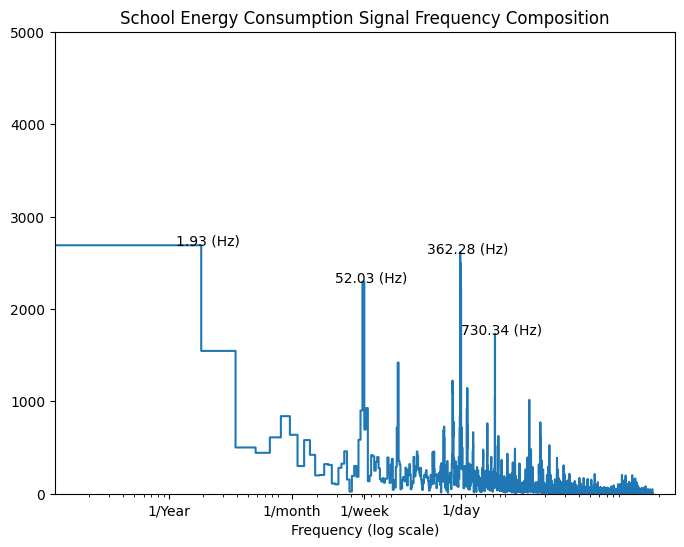

In [709]:
fft = tf.signal.rfft(df_school[f"{data_column_school}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_school[f"{data_column_school}_instantaneous"])
hours_quarters_per_year = 24 * 365.2524 * 4
years_per_dataset = n_samples_h / (hours_quarters_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 5000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks(
    [1, 12, 365.2524 / 7, 365.2524], labels=["1/Year", "1/month", "1/week", "1/day"]
)
_ = plt.xlabel("Frequency (log scale)")
_ = plt.title("School Energy Consumption Signal Frequency Composition")


# Ricerca dei valori massimi dei "pesi" delle frequenze
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
    if f_per_year[idx] >= 1 and not any(
        [
            # TODO verifica che log(last_frequency) sia una buona funzione per stabilire l'intervallo
            abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
            for last_frequency in f_per_year[top_4_indices]
        ]
        if top_4_indices
        else [False]
    ):
        top_4_indices.append(idx)
        if len(top_4_indices) == 4:
            break  # Stop after finding 4 valid frequencies
top_4_frequencies_school = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_school, top_4_magnitudes)):
    plt.annotate(
        f"{freq:.2f} (Hz)",
        (freq, mag),
        xytext=(5, 0),
        textcoords="offset points",
        ha="center",
    )

In [710]:
column_names = ["Industrial", "Residential", "School"]

best_frequencies_results = pd.DataFrame(
    [
        [
            top_4_frequencies_industrial[0],
            top_4_frequencies_residential[0],
            top_4_frequencies_school[0],
        ],
        [
            top_4_frequencies_industrial[1],
            top_4_frequencies_residential[1],
            top_4_frequencies_school[1],
        ],
        [
            top_4_frequencies_industrial[2],
            top_4_frequencies_residential[2],
            top_4_frequencies_school[2],
        ],
        [
            top_4_frequencies_industrial[3],
            top_4_frequencies_residential[3],
            top_4_frequencies_school[3],
        ],
    ],
    columns=column_names,
)

best_frequencies_results

,Industrial,Residential,School
0,1.066933,365.079802,1.927030
1,365.424665,730.711918,362.281563
2,2.133867,1.104629,52.029799
3,52.279733,1095.791720,730.344214


Possiamo notare come non siano ovvie le frequenze più importanti per ogni dataset. La scelta iniziale di utilizzare periodo dell'anno e ora del giorno (ovvero (Year sin, Year cos) e (Day sin, Day cos)) è una buona scelta per tutti i dataset: come è normale aspettarsi infatti, il consumo energetico è influenzato dal periodo dell'anno e ora del giorno, ma emerge dai dati che per ogni dataset esistono altre frequenze dominanti (come quella settimanale (~ 52 Hz) o bi-giornaliera (~ 730 Hz)) e che in ognuno dei dataset l'ordine di importanza delle frequenze è diverso.

È da considerare infine un aspetto importante nella ricerca automatica di tali massimi; tali massimi sono i risultato di un ulteriore operazione di filtraggio rispetto ai massimi reali che tiene in cosiderazione il significato di questi dati:
- sono stati esclusi i massimi < 1, in quanto non ci aspettiamo che i dati abbiano una qualche ciclicità su periodi maggiori di 1 anno
- sono stati tenuti in considerazione dei massimi locali piuttosto che assoluti, laddove infatti si presentasse un massimo vicino (entro log(max)) ad un massimo già trovato, questo non viene preso in considerazione, prendendo solo il maggiore dei due. Questo permette di avere delle frequenze finali ben distribuite, che tengano in considerazione di ciclicità più o meno lunghe

__NB__: I valori riportati delle frequenze non sono quelli reali, in quanto __le frequenze vengono normalizzate__ in base al numero di anni registrati nei dataset e sono quindi relative a 1 anno:
```python
f_per_year = f_per_dataset/years_per_dataset
```

__NB__: Le frequenze più alte di quella giornaliera sono di difficile interpretazione, in quanto vorrebbero dire che in consumi si ripetono con pattern simili all'interno della stessa giornata. Ad esempio la frequenza bi-giornaliera (~ 730 Hz) sembrerebbe indicare che ci sia una correlazione tra l'andamento dei consumi nella prima parte della giornata con l'andamento dei consumi nella seconda parte della giornata.

#### Aggiunta delle frequenze migliori

A questo punto possiamo adottare due approcci: ricavare delle frequenze "ideali" a partire dai risultati trovati, di fatto dando un'interpetazione ai dati (ad esempio se ho un risultato ~ 52 Hz interpreterò questo come frequenza di una settimana e aggiungerò 'Week cos' e 'Week sin' al dataset usando il numero di secondi in una settimana, come fatto in precedenza per anno e giorno), oppure usare direttamente quelle frequenze per stabilire il periodo di seno e coseno che useremo per convertire il timestamp, esulando dalla normale divisione del tempo in giorni, settimane, mesi, anni...

In [711]:
# Approccio Interpretativo

week = 24 * 60 * 60 * 7
half_day = 12 * 60 * 60
semester = (365.2425) * half_day

"""
Dataset Industriale: top 3 frequenze
    - 1.066933 Hz ~ 1 Hz -> Annuale
    - 365.424665 Hz ~ 365 Hz -> Giornaliera
    - 2.133867 Hz ~ 2 Hz -> Bimestrale
"""

df_industrial["Semester sin"] = np.sin(
    timestamp_seconds_industrial * (2 * np.pi / semester)
)
df_industrial["Semester cos"] = np.cos(
    timestamp_seconds_industrial * (2 * np.pi / semester)
)

"""
Dataset Residenziale: top 3 frequenze
    - 365.079802 Hz ~ 365 Hz -> Giornaliera
    - 730.711918 Hz ~ 730 Hz -> Bi-giornaliera
    - 1.104629 Hz ~ 1 Hz -> Annuale
"""

df_residential["Half-Day sin"] = np.sin(
    timestamp_seconds_residential * (2 * np.pi / half_day)
)
df_residential["Half-Day cos"] = np.cos(
    timestamp_seconds_residential * (2 * np.pi / half_day)
)

"""
Dataset Scolastico: top 3 frequenze
    - 1.92703 Hz ~ 1 Hz -> Annuale; qui la frequenza è più vicina a 2 Hz che a 1 Hz, ma dal momento che
    comunemente i consumi energetici sembrano avere più un periodo annuale che semestrale, è stato deciso di
    usare comunque la frequenza annuale. Tale risultato potrebbe essere giustificato da un dataset molt ridotto 
    rispetto agli altri due.
    - 362.281563 Hz ~ 365 Hz -> Giornaliera
    - 52.029799 Hz ~ 52 Hz -> Settimanale
"""

df_school["Week sin"] = np.sin(timestamp_seconds_school * (2 * np.pi / week))
df_school["Week cos"] = np.cos(timestamp_seconds_school * (2 * np.pi / week))

# # Decommentare per plottare nuovi grafici
# plot_cols = ['Semester sin', 'Semester cos']
# plot_features = df_industrial[plot_cols][:17532]
# plot_features.index = date_time_industrial[:17532]
# _ = plot_features.plot(subplots=True)

# plot_cols = ['Half-Day sin', 'Half-Day cos']
# plot_features = df_residential[plot_cols][:48]
# plot_features.index = date_time_residential[:48]
# _ = plot_features.plot(subplots=True)

# plot_cols = ['Week sin', 'Week cos']
# plot_features = df_school[plot_cols][:672]
# plot_features.index = date_time_school[:672]
# _ = plot_features.plot(subplots=True)

![Segnale Seno e Coseno Timestamp Periodo Settimanale](resources/timestamp_week_encoding.png "Segnale Seno e Coseno Timestamp Periodo Settimanale")
![Segnale Seno e Coseno Timestamp Periodo Semestrale](resources/timestamp_semester_encoding.png "Segnale Seno e Coseno Timestamp Periodo Semestrale")
![Segnale Seno e Coseno Timestamp Periodo Bi-Giornaliero](resources/timestamp_half_day_encoding.png "Segnale Seno e Coseno Timestamp Periodo Bi-Giornaliero")

In [712]:
# # Approccio "Stupido"

# columns_industrial = df_industrial.columns
# for column in columns_industrial:
#     if column.endswith('cos') or column.endswith('sin'):
#         df_industrial.pop(column)

# for i, frequency in enumerate(best_frequencies_results['Industrial']):
#     if i < 3: # prendiamo solo le top 3 frequenze
#         df_industrial[f'Frequency {i + 1} sin'] = np.sin(timestamp_seconds_industrial * (2 * np.pi / (year/frequency))) # year / frequency = n secondi
#         df_industrial[f'Frequency {i + 1} cos'] = np.cos(timestamp_seconds_industrial * (2 * np.pi / (year/frequency))) # year / frequency = n secondi

# columns_residential = df_residential.columns
# for column in columns_residential:
#     if column.endswith('cos') or column.endswith('sin'):
#         df_residential.pop(column)

# for i, frequency in enumerate(best_frequencies_results['Residential']):
#     if i < 3: # prendiamo solo le top 3 frequenze
#         df_residential[f'Frequency {i + 1} sin'] = np.sin(timestamp_seconds_residential * (2 * np.pi / (year/frequency))) # year / frequency = n secondi
#         df_residential[f'Frequency {i + 1} cos'] = np.cos(timestamp_seconds_residential * (2 * np.pi / (year/frequency))) # year / frequency = n secondi

# columns_school = df_school.columns
# for column in columns_school:
#     if column.endswith('cos') or column.endswith('sin'):
#         df_school.pop(column)

# for i, frequency in enumerate(best_frequencies_results['School']):
#     if i < 3: # prendiamo solo le top 3 frequenze
#         df_school[f'Frequency {i + 1} sin'] = np.sin(timestamp_seconds_school * (2 * np.pi / (year/frequency))) # year / frequency = n secondi
#         df_school[f'Frequency {i + 1} cos'] = np.cos(timestamp_seconds_school * (2 * np.pi / (year/frequency))) # year / frequency = n secondi

#### Split dei dataset

Utilizzermo una suddivisione (70%, 20%, 10%) per i set di training, validation e test. Nota che i dati non vengono mescolati casualmente prima di essere suddivisi. Questo per due motivi:

- Garantisce che sia ancora possibile suddividere i dati in finestre di campioni consecutivi.
- Garantisce che i risultati di validation/test siano più realistici, essendo valutati sui dati raccolti dopo che il modello è stato addestrato.

In [713]:
column_indices_industrial = {name: i for i, name in enumerate(df_industrial.columns)}

n_industrial = len(df_industrial)
train_df_industrial = df_industrial[0 : int(n_industrial * 0.7)]
val_df_industrial = df_industrial[int(n_industrial * 0.7) : int(n_industrial * 0.9)]
test_df_industrial = df_industrial[int(n_industrial * 0.9) :]

num_features_industrial = df_industrial.shape[1]

column_indices_residential = {name: i for i, name in enumerate(df_residential.columns)}

n_residential = len(df_residential)
train_df_residential = df_residential[0 : int(n_residential * 0.7)]
val_df_residential = df_residential[int(n_residential * 0.7) : int(n_residential * 0.9)]
test_df_residential = df_residential[int(n_residential * 0.9) :]

num_features_residential = df_residential.shape[1]

column_indices_school = {name: i for i, name in enumerate(df_school.columns)}

n_school = len(df_school)
train_df_school = df_school[0 : int(n_school * 0.7)]
val_df_school = df_school[int(n_school * 0.7) : int(n_school * 0.9)]
test_df_school = df_school[int(n_school * 0.9) :]

num_features_school = df_school.shape[1]

In [714]:
# Stampa i nomi delle colonne dei dataset
datasets_columns_indices = pd.DataFrame(
    [
        column_indices_industrial.keys(),
        column_indices_residential.keys(),
        column_indices_school.keys(),
    ]
).T
datasets_columns_indices.columns = column_names
datasets_columns_indices

,Industrial,Residential,School
0,DE_KN_industrial1_grid_import_instantaneous,DE_KN_residential1_grid_import_instantaneous,DE_KN_public1_grid_import_instantaneous
1,Day sin,Day sin,Day sin
2,Day cos,Day cos,Day cos
3,Year sin,Year sin,Year sin
4,Year cos,Year cos,Year cos
5,Semester sin,Half-Day sin,Week sin
6,Semester cos,Half-Day cos,Week cos


#### Normalizzazione dei Dati

Effetturemo una normalizzazione con media e deviazione standard: la media e la deviazione standard devono essere calcolate solo utilizzando i dati di addestramento in modo che i modelli non abbiano accesso ai valori nei set di validazione e test.

__NB__: In realtà la normalizzazione dovrebbe essere eseguita con le medie mobili.

In [715]:
train_mean_industrial = train_df_industrial.mean()
train_std_industrial = train_df_industrial.std()
train_df_industrial = (
    train_df_industrial - train_mean_industrial
) / train_std_industrial
val_df_industrial = (val_df_industrial - train_mean_industrial) / train_std_industrial
test_df_industrial = (test_df_industrial - train_mean_industrial) / train_std_industrial

train_mean_residential = train_df_residential.mean()
train_std_residential = train_df_residential.std()
train_df_residential = (
    train_df_residential - train_mean_residential
) / train_std_residential
val_df_residential = (
    val_df_residential - train_mean_residential
) / train_std_residential
test_df_residential = (
    test_df_residential - train_mean_residential
) / train_std_residential

train_mean_school = train_df_school.mean()
train_std_school = train_df_school.std()
train_df_school = (train_df_school - train_mean_school) / train_std_school
val_df_school = (val_df_school - train_mean_school) / train_std_school
test_df_school = (test_df_school - train_mean_school) / train_std_school

/tmp/ipykernel_4752/2556769267.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_industrial.keys(), rotation=90)


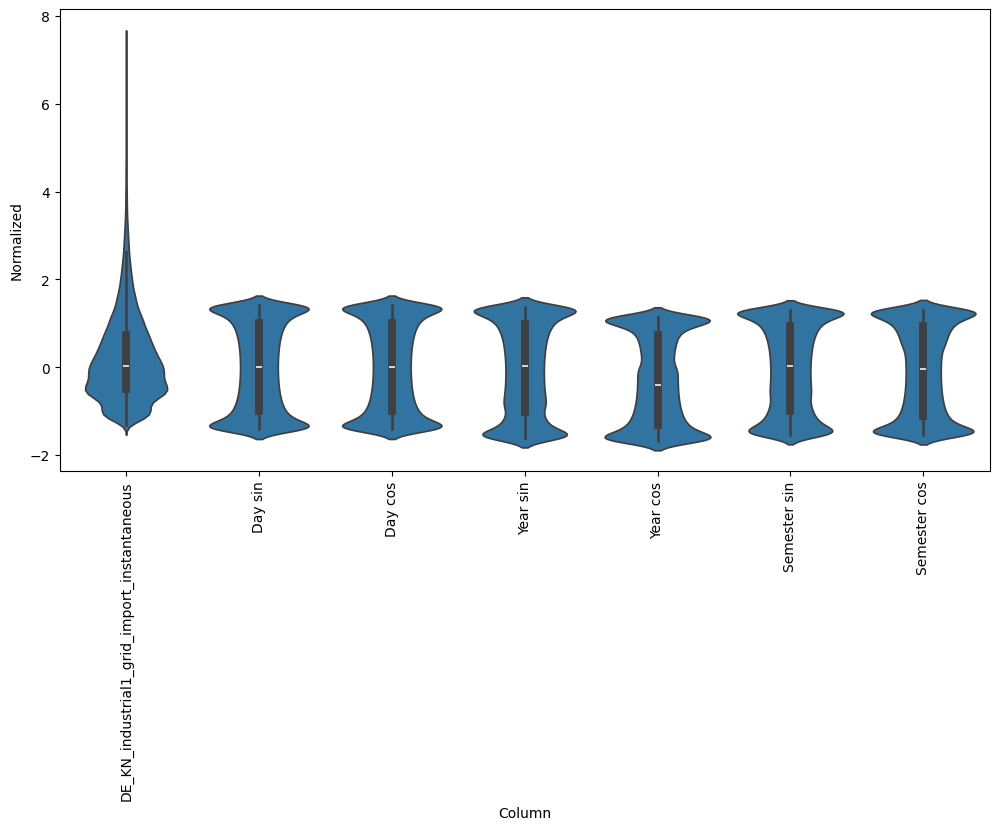

In [716]:
df_std_industrial = (df_industrial - train_mean_industrial) / train_std_industrial
df_std_industrial = df_std_industrial.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std_industrial)
_ = ax.set_xticklabels(df_industrial.keys(), rotation=90)

/tmp/ipykernel_4752/2186552112.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_residential.keys(), rotation=90)


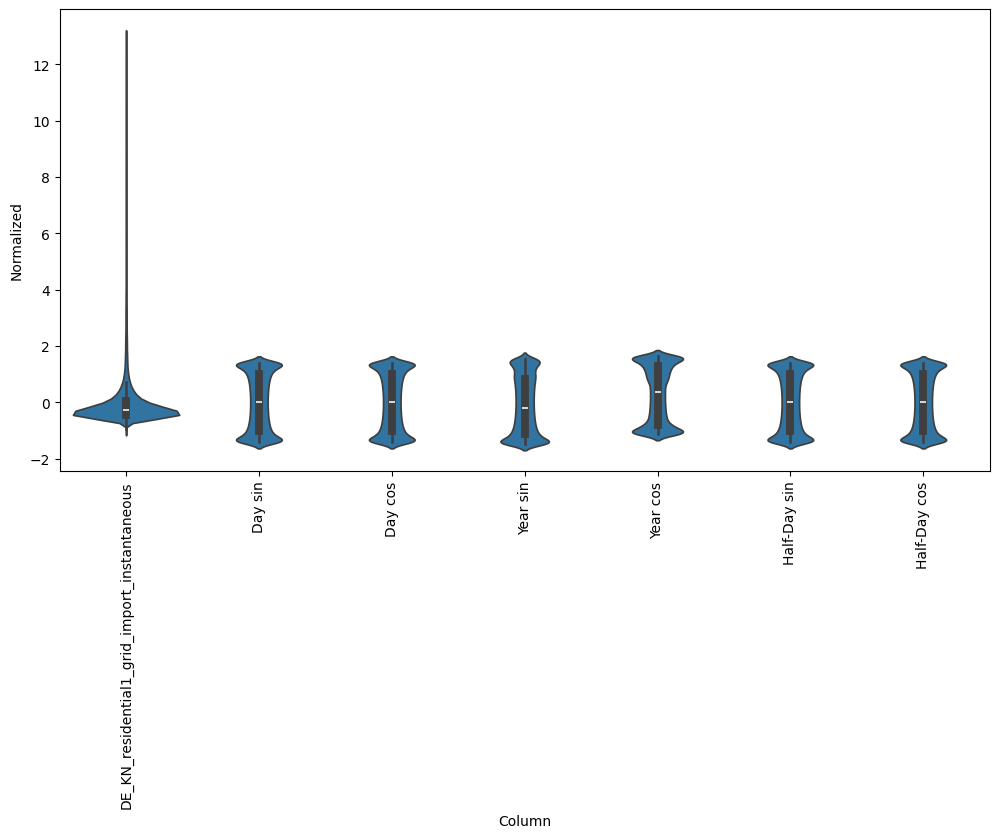

In [717]:
df_std_residential = (df_residential - train_mean_residential) / train_std_residential
df_std_residential = df_std_residential.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std_residential)
_ = ax.set_xticklabels(df_residential.keys(), rotation=90)

/tmp/ipykernel_4752/1413678702.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_school.keys(), rotation=90)


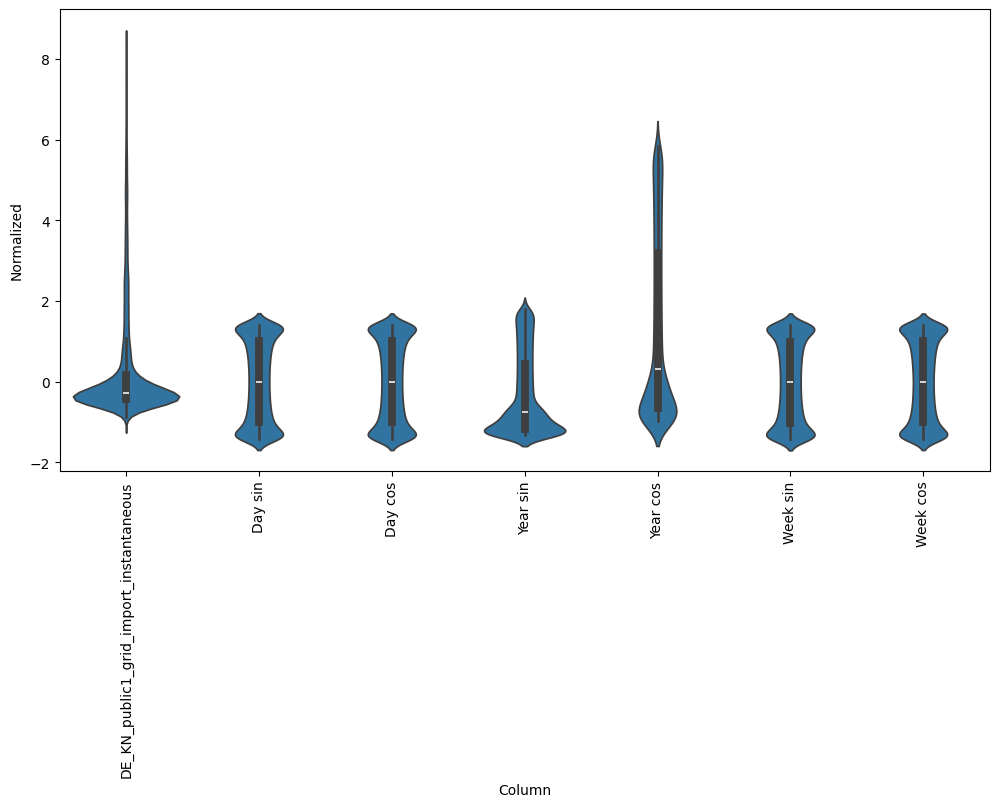

In [718]:
df_std_school = (df_school - train_mean_school) / train_std_school
df_std_school = df_std_school.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std_school)
_ = ax.set_xticklabels(df_school.keys(), rotation=90)

__NB__: La distribuzione inaspettata del coseno e seno con periodo annuale nel dataset scolastico è dovuta alla presenza di buchi nel dataset, più precisamente al fatto che questi vengano rimossi, lasciandoli infatti ci ritroveremo con la distribuzione attesa.

### Data Windowing

I modelli utilizzati faranno predizioni basandosi su una finestra di dati misurati. Il processo di data windowing serve proprio a preparare tali finestre per trainare, testare e validare i modelli.

In [719]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        """
        Genera dei batch di training a partire da un elenco input, creando n batch di input e n batch di
        label dato len(features) = n

        Args:
          features (SymbolicTensor): lista di input consecutivi

        Returns:
          (( SymbolicTensor, SymbolicTensor )): tupla contentent input e label
        """
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, plot_col: str, model=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            if len(plot_col) < 11:
                plt.ylabel(f"{plot_col} [normed]")
            else:
                plt.ylabel(f"{plot_col[:8]}... [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [15 min]")

    def make_dataset(self, data):
        """
        Prende una time series sotto forma di DataFrame e lo converte in un
        tensorflow.data.Dataset di coppie (input_window, label_window) che verrà utilizzato nel training

        Args:
          data (DataFrame): time series di dati

        Returns:
          (tensorflow.data.Dataset): dataset formato da coppie di (input_window, label_window)
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

Per effettuare una predizione sul consumo quartorario nelle prossime 24 ore (96 quarti d'ora) avremo bisogno dei seguenti parametri:
- `input_width`: 96; 24 ore di dati in input
- `label_width`: 96; 24 ore di predizione
- `shift`: 96; 24 ore nel futuro

In [720]:
example_window_generator = WindowGenerator(
    input_width=96,
    label_width=96,
    shift=96,
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
    label_columns=[f"{data_column_industrial}_instantaneous"],
)

example_window = tf.stack(
    [
        np.array(train_df_industrial[: example_window_generator.total_window_size]),
        np.array(
            train_df_industrial[
                example_window_generator.total_window_size : 2
                * example_window_generator.total_window_size
            ]
        ),
        np.array(
            train_df_industrial[
                2
                * example_window_generator.total_window_size : 3
                * example_window_generator.total_window_size
            ]
        ),
        np.array(
            train_df_industrial[
                3
                * example_window_generator.total_window_size : 4
                * example_window_generator.total_window_size
            ]
        ),
    ]
)

example_inputs, example_labels = example_window_generator.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (4, 192, 7)
Inputs shape: (4, 96, 7)
Labels shape: (4, 96, 1)


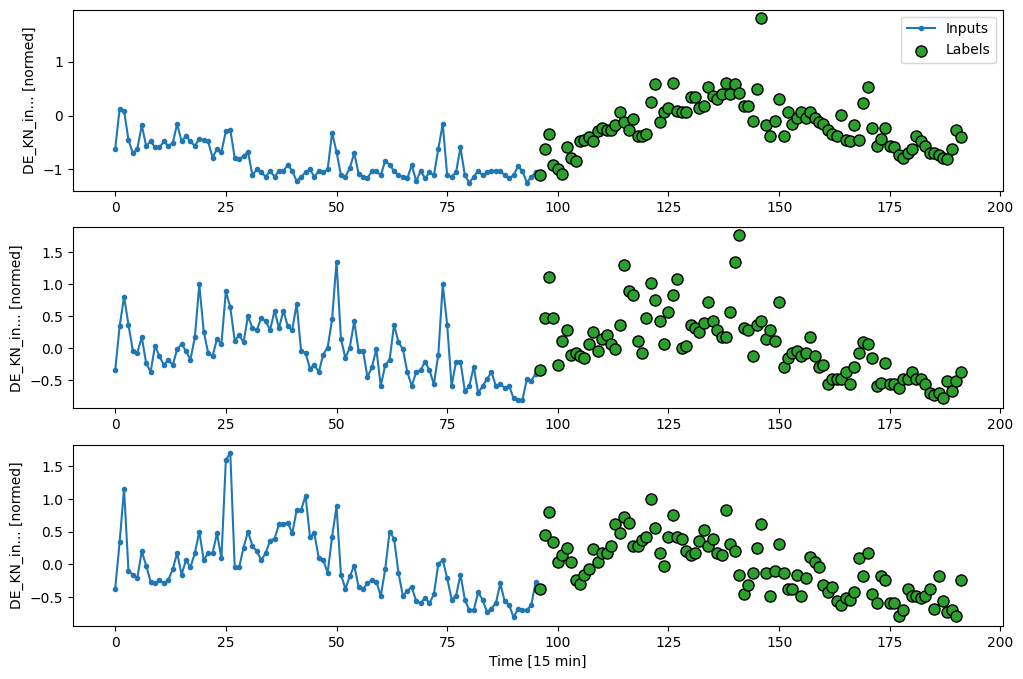

In [721]:
example_window_generator._example = example_inputs, example_labels
example_window_generator.plot(plot_col=f"{data_column_industrial}_instantaneous")

In [722]:
# Each element is an (inputs, label) pair.
example_window_generator.train.element_spec

(TensorSpec(shape=(None, 96, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))

La `batch size` in questo caso è None perché per ottenere un batch vero e proprio dobbiamo iterare sull'oggetto `tensorflow.data.Dataset` (ovvero quello che ci restituisce `train`)

In [723]:
for example_inputs, example_labels in example_window_generator.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 96, 7)
Labels shape (batch, time, features): (32, 96, 1)


2024-04-19 18:37:42.527079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Training

In [724]:
# DISCUSS l'import cumulativo è stato tolto dal dataset, confrontare i risultati con e senza

#### Modelli Single Step

I modelli single step effettuano predizioni per 1 time step futuro, date solamente le condizioni correnti (1 time step presente).

In [725]:
single_step_window_industrial = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=[f"{data_column_industrial}_instantaneous"],
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
)

single_step_window_residential = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=[f"{data_column_residential}_instantaneous"],
    train_df=train_df_residential,
    val_df=val_df_residential,
    test_df=test_df_residential,
)

single_step_window_school = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=[f"{data_column_school}_instantaneous"],
    train_df=train_df_school,
    val_df=val_df_school,
    test_df=test_df_school,
)

print(single_step_window_industrial)
print(single_step_window_residential)
print(single_step_window_school)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_KN_industrial1_grid_import_instantaneous']
Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_KN_residential1_grid_import_instantaneous']
Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_KN_public1_grid_import_instantaneous']


In [726]:
for example_inputs, example_labels in single_step_window_industrial.train.take(1):
    print("Industrial Dataset")
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")
    print("----------------------------------------------------------------")

for example_inputs, example_labels in single_step_window_residential.train.take(1):
    print("Residential Dataset")
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")
    print("----------------------------------------------------------------")

for example_inputs, example_labels in single_step_window_school.train.take(1):
    print("School Dataset")
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")
    print("----------------------------------------------------------------")

Industrial Dataset
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)
----------------------------------------------------------------
Residential Dataset
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)
----------------------------------------------------------------


2024-04-19 18:37:42.626980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 18:37:42.694753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


School Dataset
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)
----------------------------------------------------------------


2024-04-19 18:37:42.765969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


I dati riportati sopora rappresentano un batch, la cui forma è quella specificata nella creazione dell'oggetto `WindowGenerator`, per ciascuno dei tre dataset di training.

Creiamo inoltre anche una `wide_window`, che ha le stesse caratteristiche della `single_time_step`, ovvero per ogni time step di input, 1 time step di label, e una predizione da fare 1 time step nel futuro (`shift = 1`), ma ripetuto per più coppie di label e input, in questo caso per 12 ore di dati (`input_width = 48` e `label_width = 48`)

In [757]:
wide_window_industrial = WindowGenerator(
    input_width=4,
    label_width=4,
    shift=1,
    label_columns=[f"{data_column_industrial}_instantaneous"],
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
)

wide_window_residential = WindowGenerator(
    input_width=4,
    label_width=4,
    shift=1,
    label_columns=[f"{data_column_residential}_instantaneous"],
    train_df=train_df_residential,
    val_df=val_df_residential,
    test_df=test_df_residential,
)

wide_window_school = WindowGenerator(
    input_width=4,
    label_width=4,
    shift=1,
    label_columns=[f"{data_column_school}_instantaneous"],
    train_df=train_df_school,
    val_df=val_df_school,
    test_df=test_df_school,
)

print(wide_window_industrial)
print(wide_window_residential)
print(wide_window_school)

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['DE_KN_industrial1_grid_import_instantaneous']
Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['DE_KN_residential1_grid_import_instantaneous']
Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['DE_KN_public1_grid_import_instantaneous']


##### Modello Lineare



In [758]:
linear_industrial = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

linear_residential = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

linear_school = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

print(
    "Input shape:", single_step_window_industrial.example[0].shape
)
print(
    "Output shape:", linear_industrial(single_step_window_industrial.example[0]).shape
)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


Definiamo una funzione di compilazione e fit del modello che riutilizzeremo per tutti i modelli

In [759]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history

In [760]:
val_performance_industrial = {}
performance_industrial = {}

history_industrial = compile_and_fit(linear_industrial, single_step_window_industrial)

IPython.display.clear_output()
val_performance_industrial['Linear'] = linear_industrial.evaluate(single_step_window_industrial.val, return_dict=True)
performance_industrial['Linear'] = linear_industrial.evaluate(single_step_window_industrial.test, verbose=0, return_dict=True)

Epoch 1/20


1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 1.6994 - mean_absolute_error: 0.9247 - val_loss: 1.0195 - val_mean_absolute_error: 0.8360
Epoch 2/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.3529 - mean_absolute_error: 0.4126 - val_loss: 0.2824 - val_mean_absolute_error: 0.4062
Epoch 3/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - loss: 0.1631 - mean_absolute_error: 0.2760 - val_loss: 0.2137 - val_mean_absolute_error: 0.3478
Epoch 4/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.1530 - mean_absolute_error: 0.2623 - val_loss: 0.2113 - val_mean_absolute_error: 0.3457
Epoch 5/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.1526 - mean_absolute_error: 0.2621 - val_loss: 0.2119 - val_mean_absolute_error: 0.3463
Epoch 6/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.1536 - mean_absolute_error: 0.2623 - val_loss: 0.2123 - val_mean_absolute_error: 0.3466
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.2128 - mean_absolute_error: 0.3457

In [761]:
val_performance_residential = {}
performance_residential = {}

history_residential = compile_and_fit(linear_residential, single_step_window_residential)

IPython.display.clear_output()
val_performance_residential['Linear'] = linear_residential.evaluate(single_step_window_residential.val, return_dict=True)
performance_residential['Linear'] = linear_residential.evaluate(single_step_window_residential.test, verbose=0, return_dict=True)

Epoch 1/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - loss: 2.1573 - mean_absolute_error: 0.9730 - val_loss: 0.7344 - val_mean_absolute_error: 0.4608
Epoch 2/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - loss: 0.6647 - mean_absolute_error: 0.4153 - val_loss: 0.5406 - val_mean_absolute_error: 0.3612
Epoch 3/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.5440 - mean_absolute_error: 0.3478 - val_loss: 0.5336 - val_mean_absolute_error: 0.3526
Epoch 4/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.5395 - mean_absolute_error: 0.3410 - val_loss: 0.5335 - val_mean_absolute_error: 0.3503
Epoch 5/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.5400 - mean_absolute_error: 0.3407 - val_loss: 0.5335 - val_mean_absolute_error: 0.3506
Epoch 6/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.5413 - mean_absolute_error: 0.3410 - val_loss: 0.5335 - val_mean_absolute_error: 0.3510
Epoch 7/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 0.5418 - mea

In [762]:
val_performance_school = {}
performance_school = {}

history_school = compile_and_fit(linear_school, single_step_window_school)

IPython.display.clear_output()
val_performance_school['Linear'] = linear_school.evaluate(single_step_window_school.val, return_dict=True)
performance_school['Linear'] = linear_school.evaluate(single_step_window_school.test, verbose=0, return_dict=True)

Epoch 1/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5131 - mean_absolute_error: 1.4002 - val_loss: 9.2898 - val_mean_absolute_error: 2.2650
Epoch 2/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 1.6481 - mean_absolute_error: 0.9177 - val_loss: 4.0603 - val_mean_absolute_error: 1.3958
Epoch 3/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.8542 - mean_absolute_error: 0.6298 - val_loss: 2.0304 - val_mean_absolute_error: 0.9274
Epoch 4/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.4820 - mean_absolute_error: 0.4564 - val_loss: 1.1277 - val_mean_absolute_error: 0.6563
Epoch 5/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 0.3121 - mean_absolute_error: 0.3554 - val_loss: 0.6843 - val_mean_absolute_error: 0.4918
Epoch 6/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 0.2216 - mean_absolute_error: 0.2861 - val_loss: 0.4662 - val_mean_absolute_error: 0.3989
Epoch 7/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.1795 - mean_absolute_error

**Visualizzazione dei risultati**

Con i modelli addestrati posssiamo visualizzare i risultati usando il metodo `plot` di `WindowGenerator` ma su una finestra più ampia, `wide_window` definita in precedenza, in maniera tale da vedere più chiaramente la qualità del modello.

In [763]:
print('Industrial Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', linear_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

print('Residential Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', linear_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

print('School Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', linear_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

Industrial Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
Residential Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
School Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------


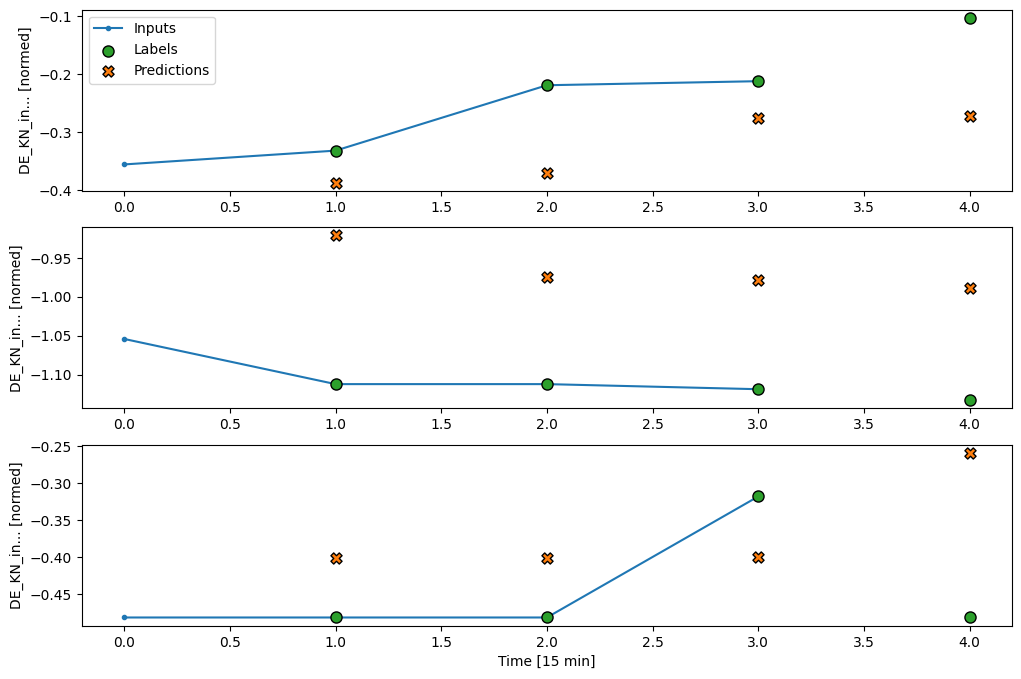

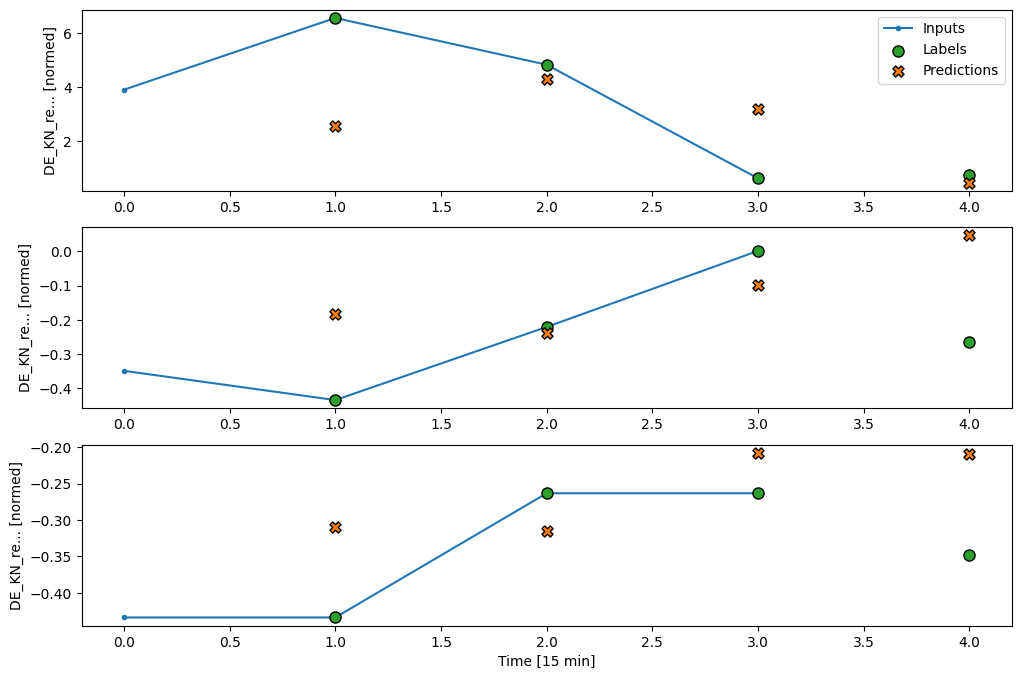

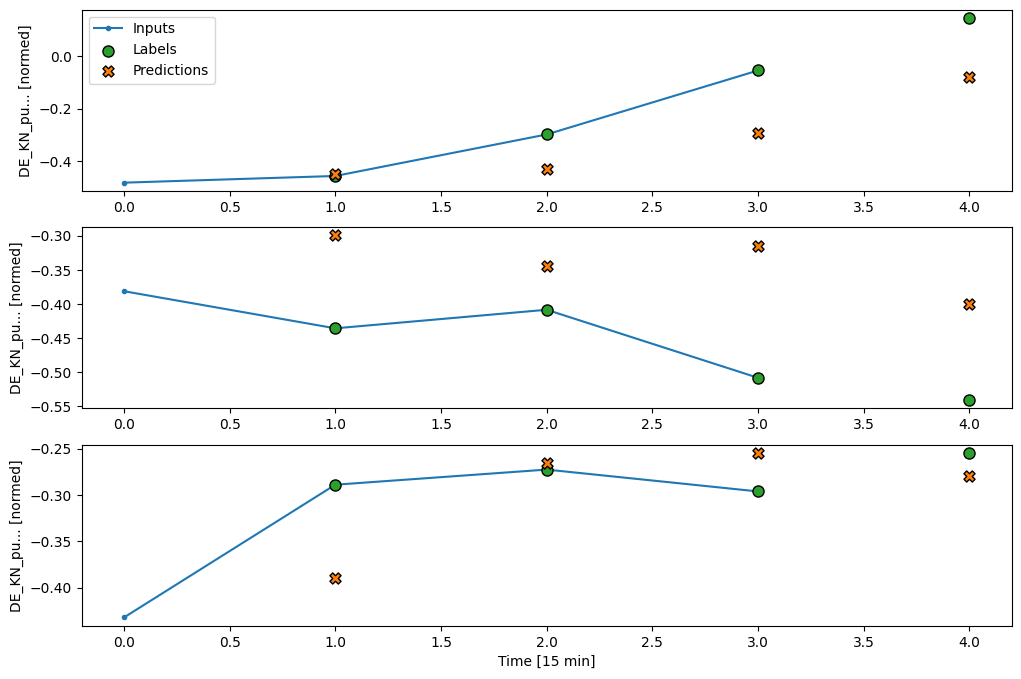

In [764]:
wide_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=linear_industrial)

wide_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=linear_residential)

wide_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=linear_school)

Con i modelli lineari possiamo vedere i pesi che il modello ha associato a ciascun input

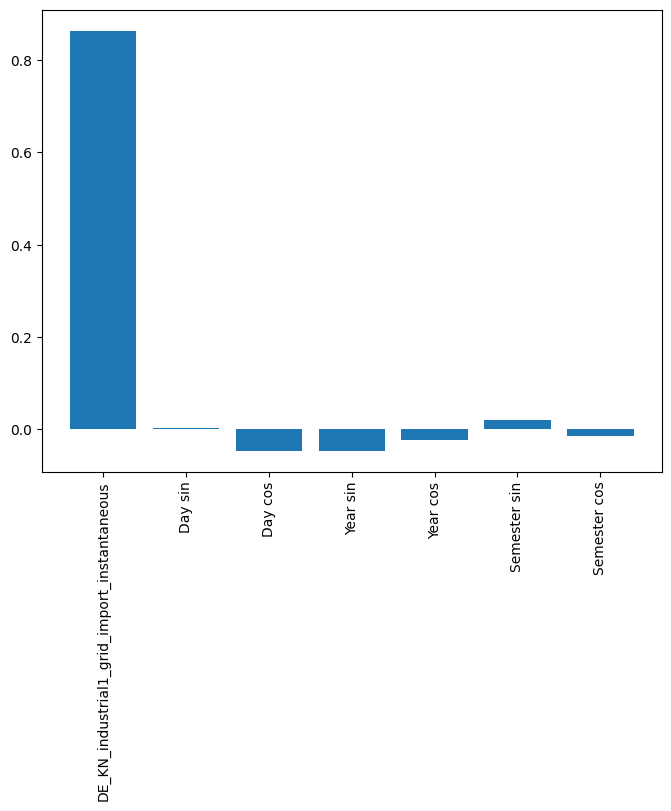

In [765]:
plt.bar(x = range(len(train_df_industrial.columns)),
        height=linear_industrial.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_industrial.columns)))
_ = axis.set_xticklabels(train_df_industrial.columns, rotation=90)

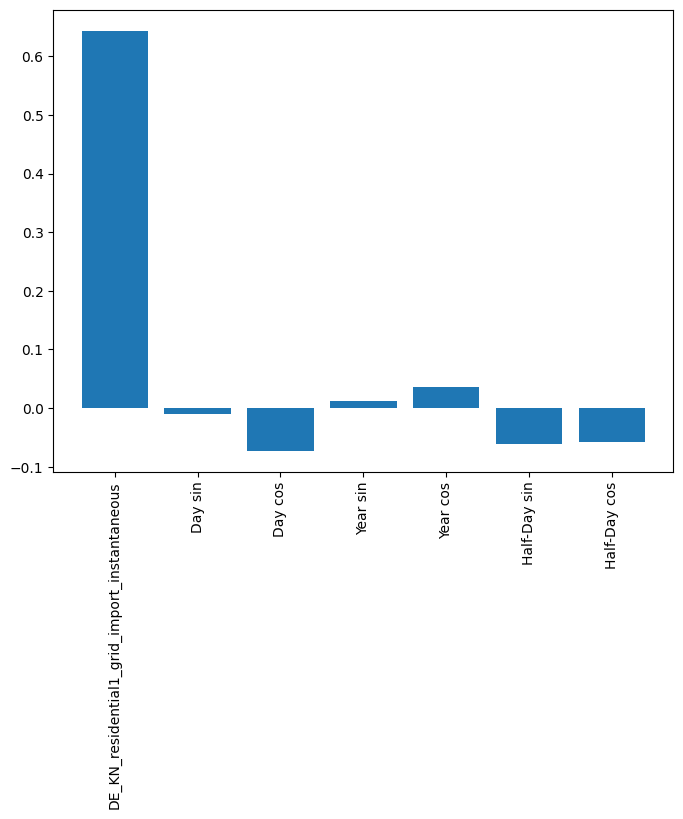

In [766]:
plt.bar(x = range(len(train_df_residential.columns)),
        height=linear_residential.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_residential.columns)))
_ = axis.set_xticklabels(train_df_residential.columns, rotation=90)

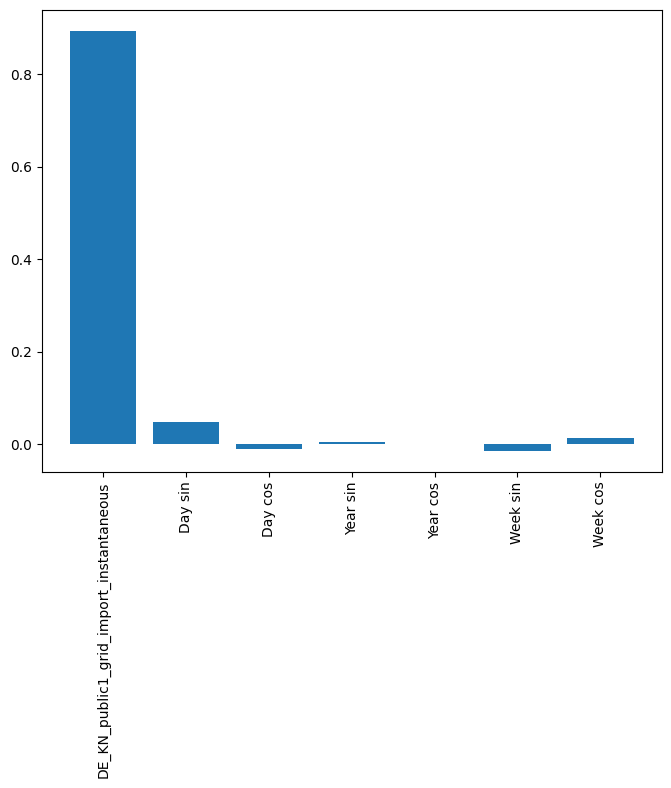

In [767]:
plt.bar(x = range(len(train_df_school.columns)),
        height=linear_school.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_school.columns)))
_ = axis.set_xticklabels(train_df_school.columns, rotation=90)

##### Recurrent Neural Network

Una rete neurale ricorrente (RNN) è un tipo di rete neurale adatta ai dati di serie temporali. Gli RNN elaborano una serie temporale passo dopo passo, mantenendo uno stato interno da un passo temporale all'altro.

In [768]:
lstm_model_industrial = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model_residential = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model_school = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [769]:
print('Industrial Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', lstm_model_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

print('Residential Dataset')
print('Input shape:', wide_window_residential.example[0].shape)
print('Output shape:', lstm_model_residential(wide_window_residential.example[0]).shape)
print('-------------------------------------------------------------------------')

print('School Dataset')
print('Input shape:', wide_window_school.example[0].shape)
print('Output shape:', lstm_model_school(wide_window_school.example[0]).shape)
print('-------------------------------------------------------------------------')

Industrial Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
Residential Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
School Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------


In [770]:
history_industrial = compile_and_fit(lstm_model_industrial, wide_window_industrial)

IPython.display.clear_output()
val_performance_industrial['LSTM'] = lstm_model_industrial.evaluate(wide_window_industrial.val, return_dict=True)
performance_industrial['LSTM'] = lstm_model_industrial.evaluate(wide_window_industrial.test, verbose=0, return_dict=True)

411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.2661 - mean_absolute_error: 0.3887


In [771]:
history_residential = compile_and_fit(lstm_model_residential, wide_window_residential)

IPython.display.clear_output()
val_performance_residential['LSTM'] = lstm_model_residential.evaluate(wide_window_residential.val, return_dict=True)
performance_residential['LSTM'] = lstm_model_residential.evaluate(wide_window_residential.test, verbose=0, return_dict=True)

397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.5275 - mean_absolute_error: 0.3483


In [772]:
history_school = compile_and_fit(lstm_model_school, wide_window_school)

IPython.display.clear_output()
val_performance_school['LSTM'] = lstm_model_school.evaluate(wide_window_school.val, return_dict=True)
performance_school['LSTM'] = lstm_model_school.evaluate(wide_window_school.test, verbose=0, return_dict=True)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.2285 - mean_absolute_error: 0.2952


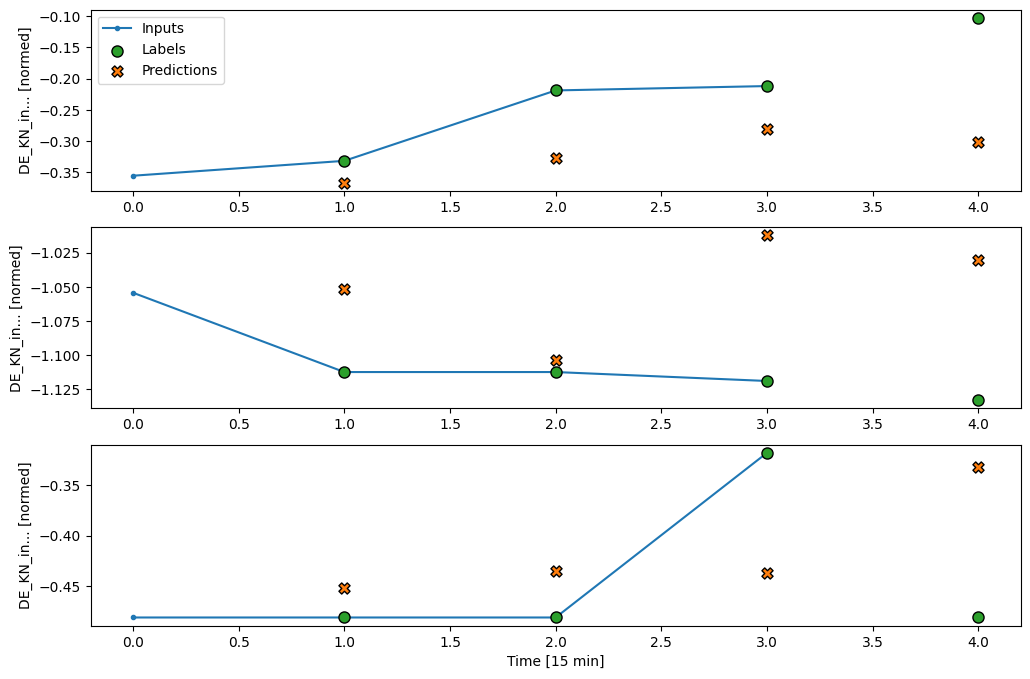

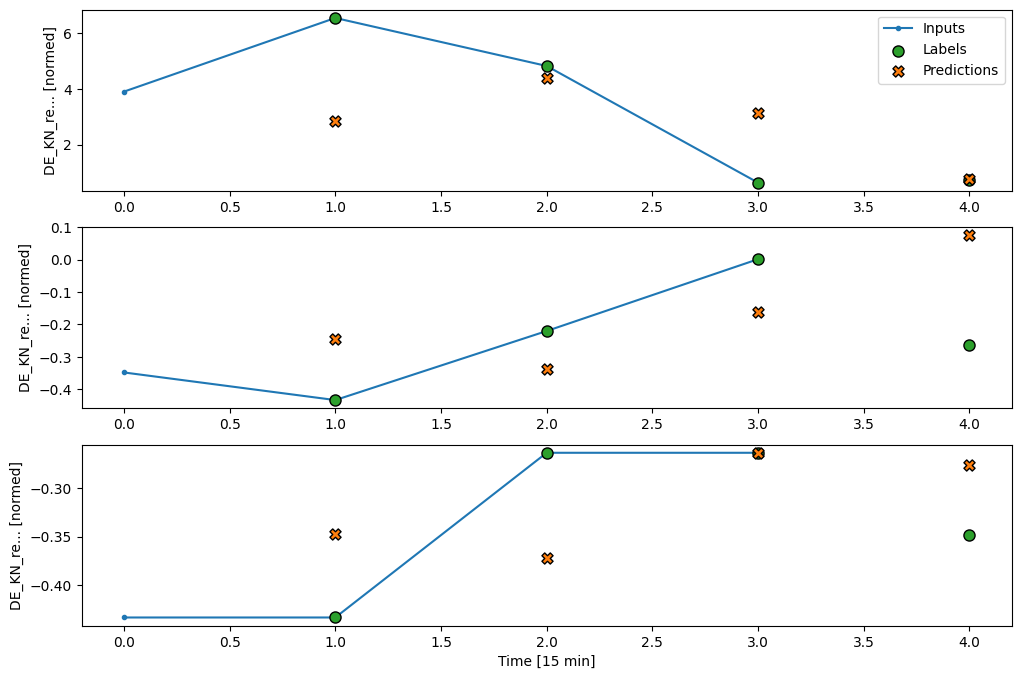

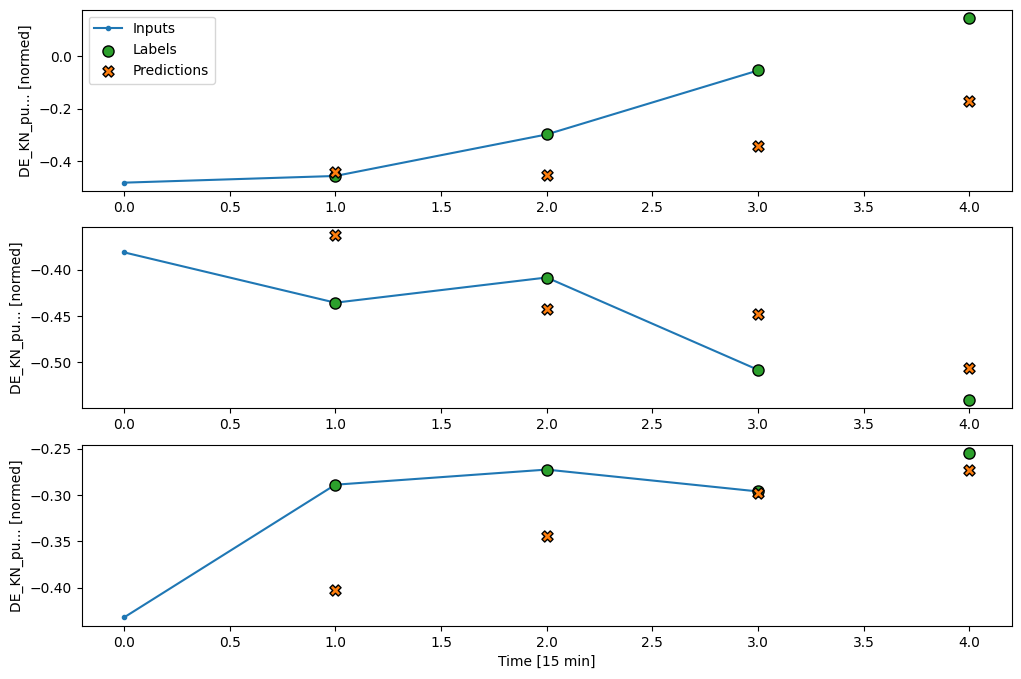

In [773]:
wide_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=lstm_model_industrial)

wide_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=lstm_model_residential)

wide_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=lstm_model_school)

##### Performance dei modelli single-step

In [774]:
print('Industrial Dataset')
print(val_performance_industrial)
print('-------------------------------------------------------------------------')

print('Residential Dataset')
print(val_performance_residential)
print('-------------------------------------------------------------------------')

print('School Dataset')
print(val_performance_school)
print('-------------------------------------------------------------------------')

Industrial Dataset
{'Linear': {'loss': 0.21227866411209106, 'mean_absolute_error': 0.34657296538352966}, 'LSTM': {'loss': 0.2657133936882019, 'mean_absolute_error': 0.388991117477417}}
-------------------------------------------------------------------------
Residential Dataset
{'Linear': {'loss': 0.5336316227912903, 'mean_absolute_error': 0.3517802655696869}, 'LSTM': {'loss': 0.5137907266616821, 'mean_absolute_error': 0.34837350249290466}}
-------------------------------------------------------------------------
School Dataset
{'Linear': {'loss': 0.29012221097946167, 'mean_absolute_error': 0.28422340750694275}, 'LSTM': {'loss': 0.2316427379846573, 'mean_absolute_error': 0.2962370812892914}}
-------------------------------------------------------------------------


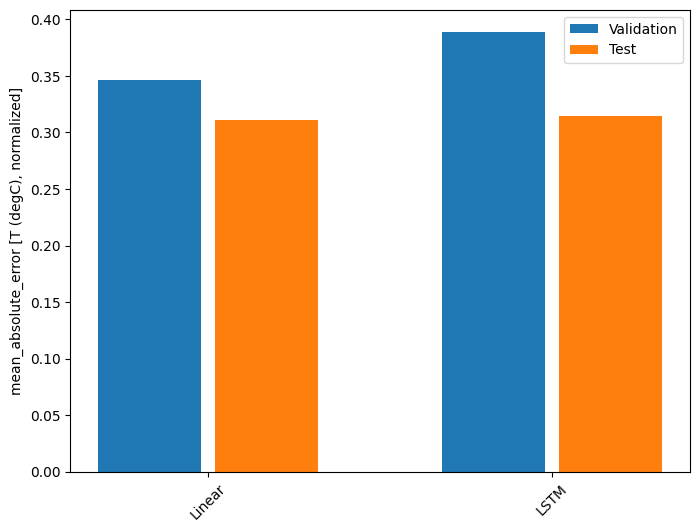

In [775]:
x = np.arange(len(performance_industrial))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_industrial.values()]
test_mae = [v[metric_name] for v in performance_industrial.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_industrial.keys(),
           rotation=45)
_ = plt.legend()

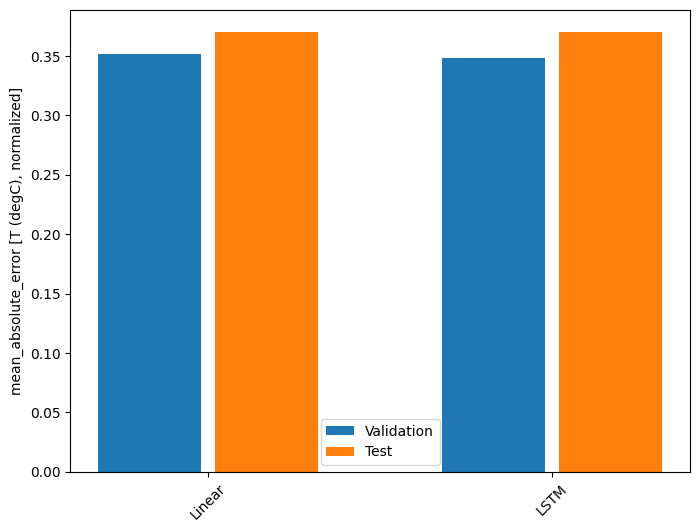

In [776]:
x = np.arange(len(performance_residential))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_residential.values()]
test_mae = [v[metric_name] for v in performance_residential.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_residential.keys(),
           rotation=45)
_ = plt.legend()

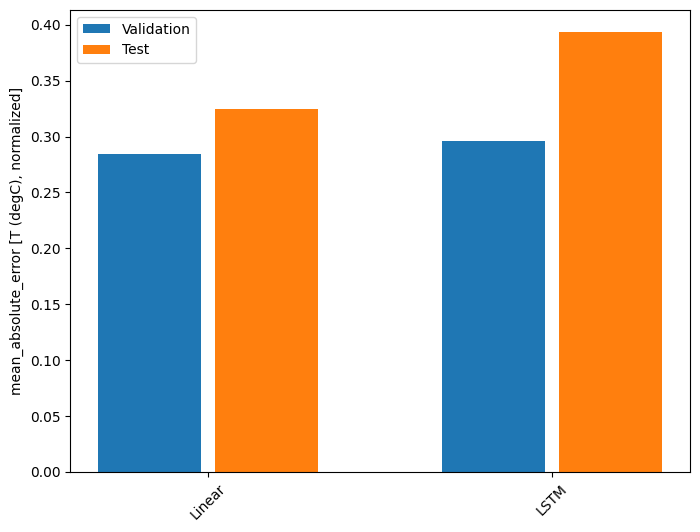

In [777]:
x = np.arange(len(performance_school))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_school.values()]
test_mae = [v[metric_name] for v in performance_school.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_school.keys(),
           rotation=45)
_ = plt.legend()

Possiamo notare, in conclusione, come la performance tra il modello lineare, che usiamo come baseline, e l'RNN, non è molta, con l'RNN che risulta essere addirittura peggiore. È stato anche notato come all'aumentare della finestra di input (è stata impostata in precedenza `input width = 96*7`, dunque una settimana), la performance del modello sia anche peggiore. Questo potrebbe essere dovuto dal fatto che al fine di predirre il consumo nei prossimi 15 minuti, il dato più importante è probabilmente il consumo attuale, o comunque recente, dunque fornire in input una finestra più ampia potrebbe peggiorare il risultato.

##### Modelli Multi Step

Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): None

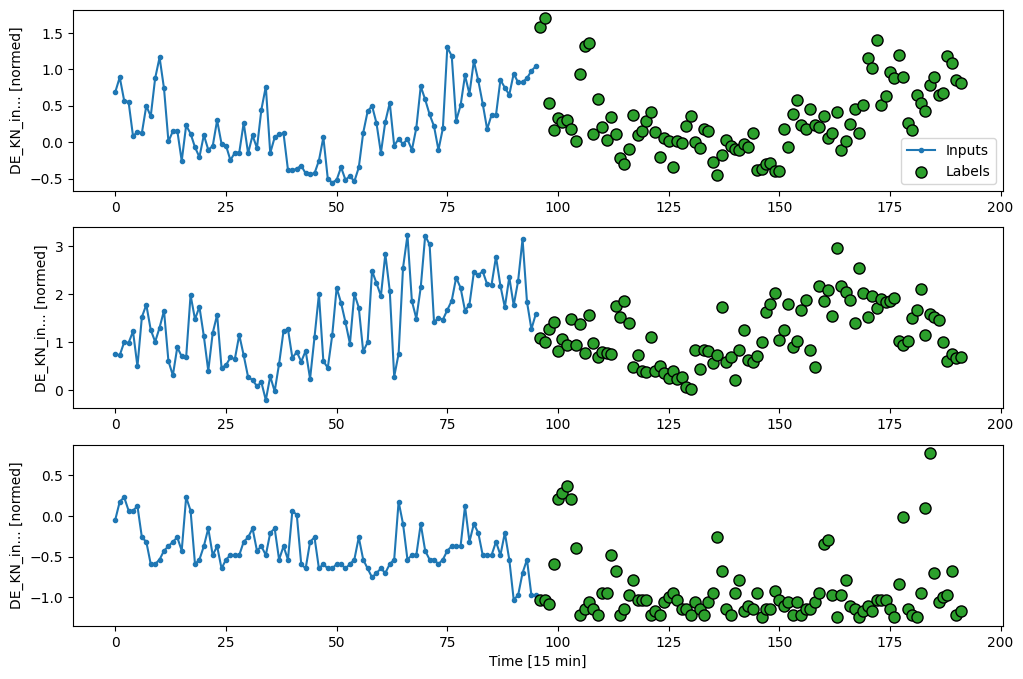

In [802]:
OUT_STEPS = 96
multi_window_industrial = WindowGenerator(input_width=96,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df_industrial,
                               val_df=val_df_industrial,
                               test_df=test_df_industrial)

multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous')
multi_window_industrial

##### Modello lineare

In [803]:
multi_val_performance_industrial = {}
multi_performance_industrial = {}

405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1014 - mean_absolute_error: 0.0938


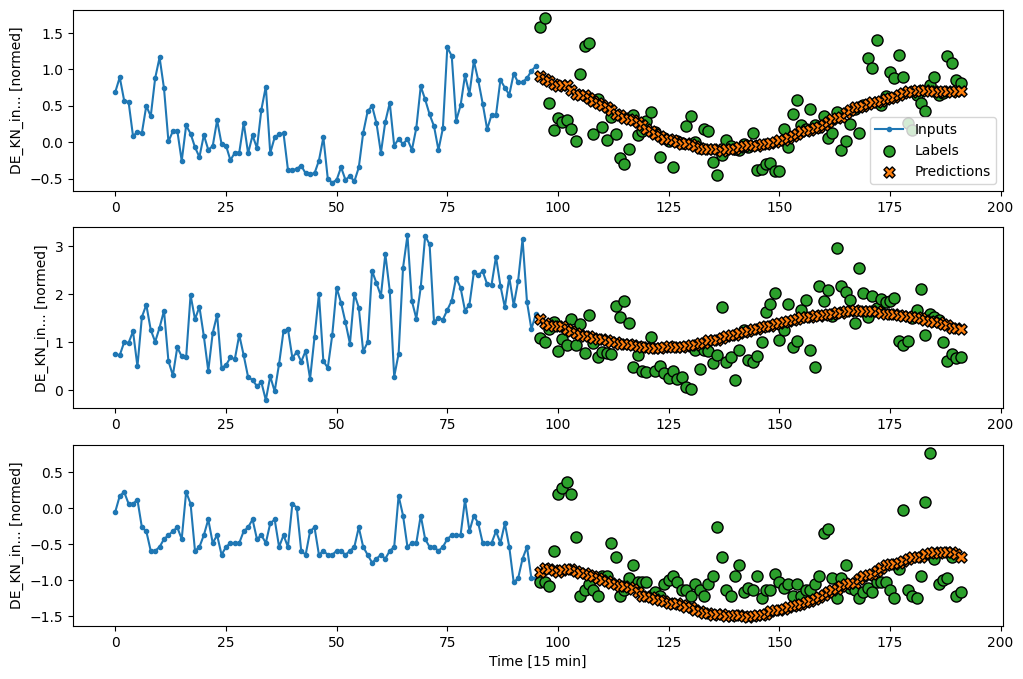

In [804]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_industrial,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_industrial])
])

history = compile_and_fit(multi_linear_model, multi_window_industrial)

IPython.display.clear_output()
multi_val_performance_industrial['Linear'] = multi_linear_model.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['Linear'] = multi_linear_model.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=multi_linear_model)

##### Modello RNN 

##### Modello RNN Autoregressivo

In [805]:
class FeedBack(tf.keras.Model):
	def __init__(self, units, out_steps):
		super().__init__()
		self.out_steps = out_steps
		self.units = units
		self.lstm_cell = tf.keras.layers.LSTMCell(units)
		# Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
		self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
		self.dense = tf.keras.layers.Dense(
		num_features_industrial
		)  # TODO adatta per tutti i dataset

	def warmup(self, inputs):
		# inputs.shape => (batch, time, features)
		# x.shape => (batch, lstm_units)
		x, *state = self.lstm_rnn(inputs)

		# predictions.shape => (batch, features)
		prediction = self.dense(x)
		return prediction, state
	
	def call(self, inputs, training=None):
		# Use a TensorArray to capture dynamically unrolled outputs.
		predictions = []
		# Initialize the LSTM state.
		prediction, state = self.warmup(inputs)

		# Insert the first prediction.
		predictions.append(prediction)

		# Run the rest of the prediction steps.
		for n in range(1, self.out_steps):
			# Use the last prediction as input.
			x = prediction
			# Execute one lstm step.
			x, state = self.lstm_cell(x, states=state,
									training=training)
			# Convert the lstm output to a prediction.
			prediction = self.dense(x)
			# Add the prediction to the output.
			predictions.append(prediction)

		# predictions.shape => (time, batch, features)
		predictions = tf.stack(predictions)
		# predictions.shape => (batch, time, features)
		predictions = tf.transpose(predictions, [1, 0, 2])
		return predictions	

In [806]:
feedback_model_industrial = FeedBack(units=32, out_steps=OUT_STEPS)

In [807]:
prediction, state = feedback_model_industrial.warmup(multi_window_industrial.example[0])
prediction.shape

TensorShape([32, 7])

In [808]:
print('Output shape (batch, time, features): ', feedback_model_industrial(multi_window_industrial.example[0]).shape)

Output shape (batch, time, features):  (32, 96, 7)


405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2159 - mean_absolute_error: 0.2140


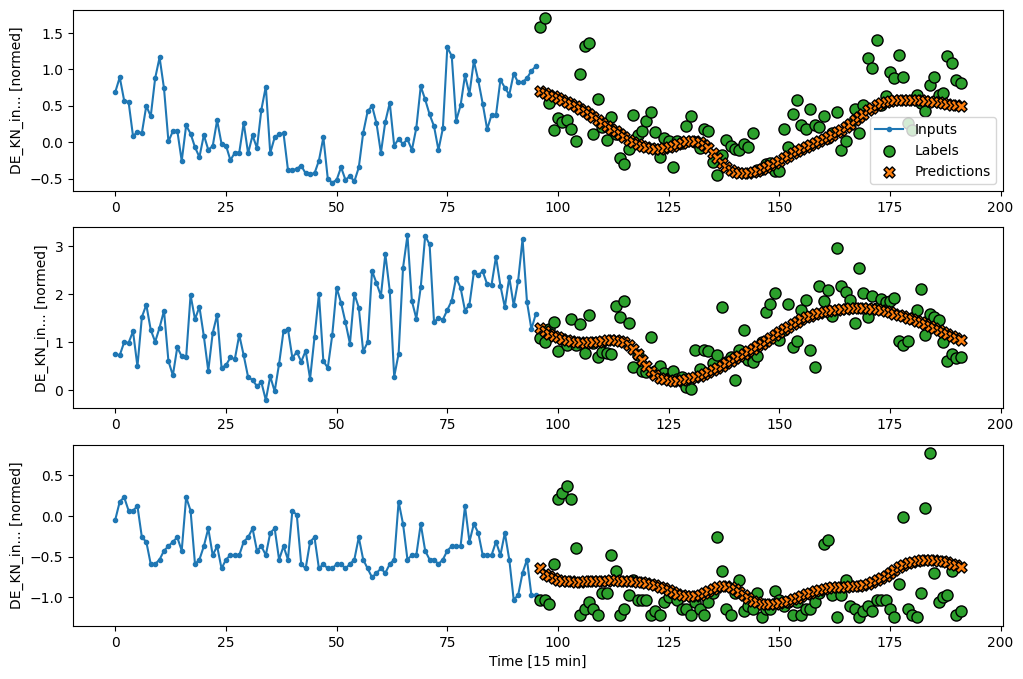

In [809]:
history = compile_and_fit(feedback_model_industrial, multi_window_industrial)

IPython.display.clear_output()

multi_val_performance_industrial['AR LSTM'] = feedback_model_industrial.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['AR LSTM'] = feedback_model_industrial.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=feedback_model_industrial)